In [ ]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os
import datetime

import keras
from tensorflow.keras import layers

import PIL.Image as Image


# Import flower dataset and split training data

In [ ]:
(training_set,validation_set), dataset_info= tfds.load(
    "tf_flowers",
    with_info = True,
    as_supervised = True,
    split=['train[:70%]','train[70%:]'],
)

num_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes

In [ ]:
print("Total Number of Classes: {}".format(num_classes))
print("Total number of Training Images : {}".format(num_examples))

Total Number of Classes: 5
Total number of Training Images : 3670


In [ ]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and create data batches

In [ ]:
IMAGE_RES = 224
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

# Setup train and validation batches


In [ ]:
train_batches      = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
KERAS_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(KERAS_URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))


In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor.trainable = False
# Setup false trainable in order to only train on your layers

# Attach a classification Head

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(5,activation='relu'),
  layers.Dense(5),
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 6405      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 30        
Total params: 2,264,419
Trainable params: 6,435
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [ ]:
%%time

EPOCHS = 100

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

early_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)


history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks = [early_callbacks])

Epoch 1/100
81/81 [==============================] - 10s 84ms/step - loss: 1.4415 - accuracy: 0.4008 - val_loss: 1.0310 - val_accuracy: 0.6521
Epoch 2/100
81/81 [==============================] - 4s 50ms/step - loss: 0.9492 - accuracy: 0.6787 - val_loss: 0.8655 - val_accuracy: 0.7784
Epoch 3/100
81/81 [==============================] - 4s 51ms/step - loss: 0.7960 - accuracy: 0.7964 - val_loss: 0.7605 - val_accuracy: 0.8129
Epoch 4/100
81/81 [==============================] - 4s 51ms/step - loss: 0.6910 - accuracy: 0.8369 - val_loss: 0.6866 - val_accuracy: 0.8220
Epoch 5/100
81/81 [==============================] - 4s 51ms/step - loss: 0.5888 - accuracy: 0.8613 - val_loss: 0.6316 - val_accuracy: 0.8465
Epoch 6/100
81/81 [==============================] - 4s 51ms/step - loss: 0.5496 - accuracy: 0.8734 - val_loss: 0.5952 - val_accuracy: 0.8520
Epoch 7/100
81/81 [==============================] - 4s 51ms/step - loss: 0.5206 - accuracy: 0.8840 - val_loss: 0.5708 - val_accuracy: 0.8529
Epoch

In [ ]:
  def show_model_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs_range = range(len(acc))

    print("Maximum training accuracy: ",max(acc))
    print("Maximum validation accuracy: ",max(val_acc))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.legend("lower right ")
    plt.title("Training and Validation accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label="Training loss")
    plt.plot(epochs_range,val_loss,label="Validation loss")
    plt.legend("upper right")
    plt.title("Training and Validation loss")

    plt.show()

Maximum training accuracy:  0.9902685880661011
Maximum validation accuracy:  0.8819255232810974


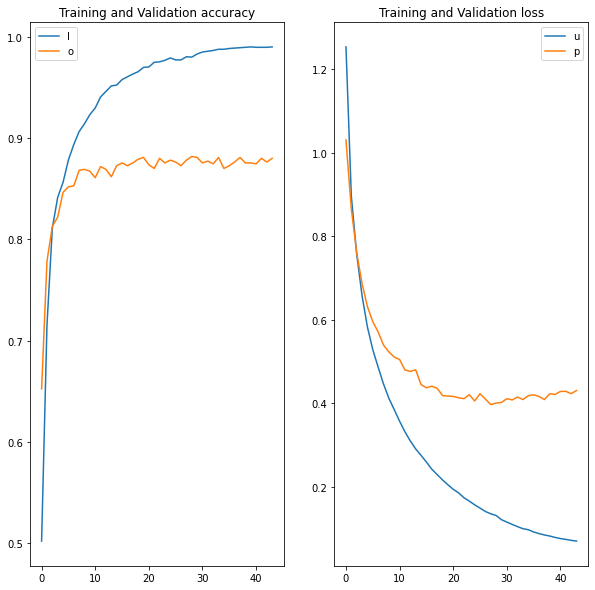

In [ ]:
show_model_history(history)

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

# View and plot predictions

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['sunflowers', 'daisy', 'sunflowers', 'daisy', 'dandelion',
       'dandelion', 'daisy', 'roses', 'roses', 'tulips', 'roses', 'roses',
       'tulips', 'tulips', 'roses', 'dandelion', 'tulips', 'sunflowers',
       'roses', 'dandelion', 'dandelion', 'daisy', 'tulips', 'sunflowers',
       'dandelion', 'sunflowers', 'tulips', 'roses', 'sunflowers',
       'dandelion', 'tulips', 'roses'], dtype='<U10')

In [ ]:
print("Labels:",label_batch)
print("Predicted labels:",predicted_ids)

Labels: [3 1 3 1 0 0 1 4 4 2 4 4 2 2 4 0 2 3 4 0 0 1 2 3 0 3 2 4 3 0 2 4]
Predicted labels: [3 1 3 1 0 0 1 4 4 2 4 4 2 2 4 0 2 3 4 0 0 1 2 3 0 3 2 4 3 0 2 4]


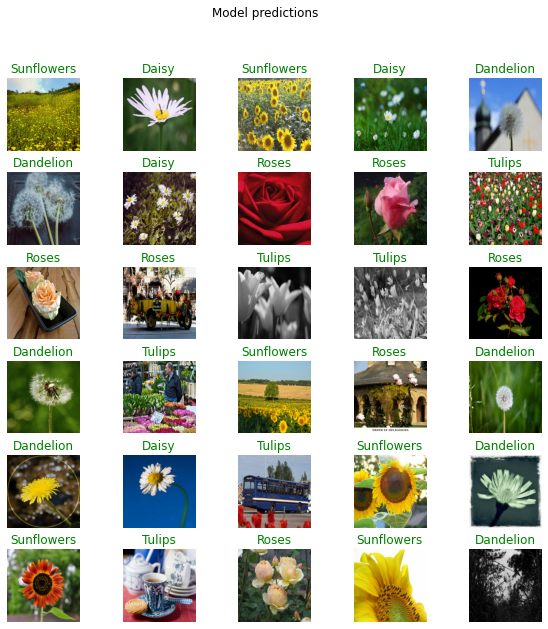

In [ ]:
plt.figure(figsize=(10,10))

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(),color=color)
  plt.axis('off')
  _=plt.suptitle('Model predictions')

# Now lets try compiling and fitting the model with `https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4`
* The inception model accepts 299 299 3 image sizes


# Lets make the images 299 299 3

In [ ]:
IMAGE_RES = 299

def format_image_inception(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

### Setup train and validation batches with 299 299 3 size

In [ ]:
train_batches      = training_set.shuffle(num_examples//4).map(format_image_inception).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image_inception).batch(BATCH_SIZE).prefetch(1)

In [ ]:
KERAS_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4'

feature_extractor = hub.KerasLayer(KERAS_URL,
                                   input_shape=(IMAGE_RES,IMAGE_RES,3),
                                   trainable = False)

In [ ]:
model = tf.keras.Sequential([
        feature_extractor,
        layers.Dense(5,activation="relu"),
        layers.Dense(5),
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 2048)              21802784  
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 10245     
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 30        
Total params: 21,813,059
Trainable params: 10,275
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
%%time

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 100

early_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

history = model.fit(
    train_batches,
    epochs = EPOCHS,
    validation_data = validation_batches,
    callbacks= [early_callbacks]
)

Epoch 1/100
81/81 [==============================] - 17s 182ms/step - loss: 0.6231 - accuracy: 0.8122 - val_loss: 0.4584 - val_accuracy: 0.8438
Epoch 2/100
81/81 [==============================] - 14s 174ms/step - loss: 0.3861 - accuracy: 0.8926 - val_loss: 0.3776 - val_accuracy: 0.8810
Epoch 3/100
81/81 [==============================] - 14s 173ms/step - loss: 0.2869 - accuracy: 0.9220 - val_loss: 0.3372 - val_accuracy: 0.8883
Epoch 4/100
81/81 [==============================] - 14s 171ms/step - loss: 0.2622 - accuracy: 0.9277 - val_loss: 0.3206 - val_accuracy: 0.8874
Epoch 5/100
81/81 [==============================] - 14s 171ms/step - loss: 0.2191 - accuracy: 0.9427 - val_loss: 0.3102 - val_accuracy: 0.8937
Epoch 6/100
81/81 [==============================] - 14s 172ms/step - loss: 0.1877 - accuracy: 0.9463 - val_loss: 0.2992 - val_accuracy: 0.9028
Epoch 7/100
81/81 [==============================] - 14s 172ms/step - loss: 0.1796 - accuracy: 0.9495 - val_loss: 0.3054 - val_accuracy:

Maximum training accuracy:  0.9595173001289368
Maximum validation accuracy:  0.9028156399726868


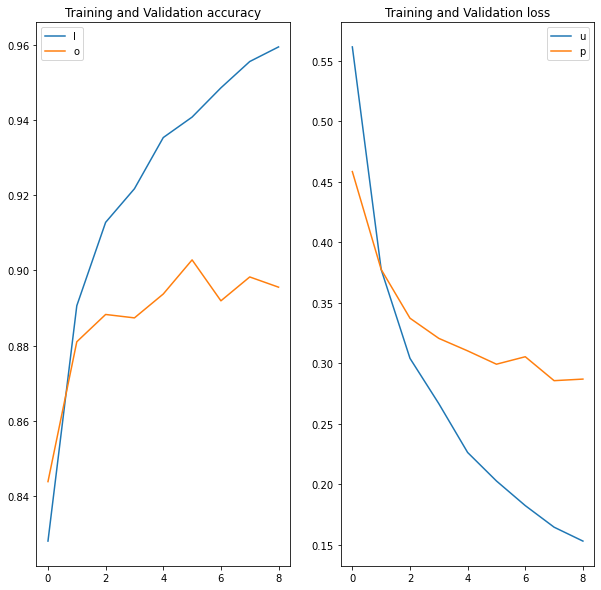

In [ ]:
show_model_history(history)

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['sunflowers', 'daisy', 'sunflowers', 'daisy', 'daisy', 'dandelion',
       'daisy', 'roses', 'roses', 'tulips', 'roses', 'tulips', 'tulips',
       'tulips', 'roses', 'dandelion', 'tulips', 'sunflowers', 'daisy',
       'dandelion', 'dandelion', 'daisy', 'tulips', 'sunflowers',
       'dandelion', 'sunflowers', 'roses', 'roses', 'sunflowers',
       'dandelion', 'tulips', 'roses'], dtype='<U10')

In [ ]:
print("Labesl: ",label_batch)
print("Predicted Labels: ",predicted_ids)

Labesl:  [3 1 3 1 0 0 1 4 4 2 4 4 2 2 4 0 2 3 4 0 0 1 2 3 0 3 2 4 3 0 2 4]
Predicted Labels:  [3 1 3 1 1 0 1 4 4 2 4 2 2 2 4 0 2 3 1 0 0 1 2 3 0 3 4 4 3 0 2 4]


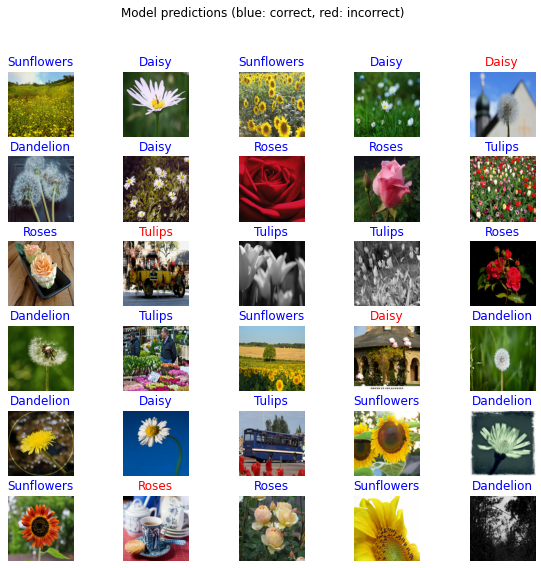

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")